# Mission Simulation
Scripts to simulate the behaviour and conditions of the satellite in different orbits, under different plans of operation.

### Setup Instructions

The following instructions were created on Ubuntu on the Windows Subsystem for Linux on a Windows 10 laptop, but should work for any system. If you are on a Windows system, the recommended setup is using the [Windows Subsystem for Linux](https://docs.microsoft.com/en-us/windows/wsl/about). These are the steps:

1. Install [conda 3](https://conda.io/en/latest/miniconda.html). If you are using WSL, the instructions [here](https://gist.github.com/kauffmanes/5e74916617f9993bc3479f401dfec7da). Conda is a python package manager to keep track of all the dependencies in your project, and it'll make it painless. Read [this guide](https://conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html).
2. Clone this github repository on your system using `git clone https://github.com/HeronMkII/mission-sim`
3. Load up the conda environment from the file `conda env create -f sims-env.yml` 
4. Activate the environment `conda activate utat-sims`
5. Run the notebook server: `jupyter notebook`, and open up the link on your browser to run this notebook

### 0. Imports and Global Constants

In [3]:
# 0.1 Imports
import numpy as np
import matplotlib.pyplot as plt
from openpyxl import load_workbook
import os.path
import datetime as dt


In [4]:
# 0.2 Physical Constants
o = 5.67*np.power(10.0,-8.0);     #Stephan-Boltzmann Constant

### 1. Orbit Object
Every orbit from STK can be imported as a class

In [5]:
class Orbit (object):

    # wb_name [string] - name of the Excel workbook containing beta angles and exlipse fractions
    # sh_name [string] - name of the sheet to look at in the owrkboo
    def __init__(self, wb_name, sh_name, n_days, T, alt, launch_date):
        # Allocate arrays
        self.beta_angles = np.zeros(n_days + 1)
        self.eclipse_frc = np.zeros(n_days + 1) 
        self.launch_date = launch_date
        self.T_orbit = T #minutes;
        self.alt = alt
        # CAUTION: beta_angles[0] and eclipse_frc[0] are ignored. Day 1, the first day, is stored in [1]
        
        self.orbits_per_day = int(np.floor(24*360/T))
        
        # Import notebook (no formulas, data only)
        wb = load_workbook(wb_name, data_only=True)

        # Loop through each day
        row = 2
        while (wb[sh_name]["D"+str(row)].value != None):
            self.beta_angles[row - 1] = wb[sh_name]['E'+str(row)].value
            self.eclipse_frc[row - 1] = wb[sh_name]['G'+str(row)].value
            row += 1
    

### 2. Satellite Objects

Here we define the satellite properties, concept of operations and other operational parameters that simulate our satellite.

#### 2.1 Satellite constants and Assumptions
Assumptions and constants regarding the thermal properties, time between radio tranmissions and power generation from solar panels

In [6]:
# 1.1 Define Class of Thermal Properties
class THM_Properties(object):
    def __init__(self):
        return
    # Thermal Assumptions
    tot = 0.1418;           #Total Area [m^2]
    a = 0.72;               #Absorptivity 
    e = 0.58;               #Emissivity
    Ra = 0.1;               #Absorptivity
    Re = 0.8;               #Emissivity
    Arad = 0;               #Area of Radiator [m^2]
    K = 0.08;               #Bus-Payload Conductance [W/K]
    Pmax = 0.2;             #Max heat disipation 
    
    sta_coldT = 10          # Minimum temperature during stasis [C]
    exp_coldT = 33          # Minimum temperature during experiment [C]
    

In [7]:
# 1.2 Define communication time and length
class COM_Properties(object):
    def __init__(self):
        return
    beacon_time = 1        # length of a beacon transmission in minutes
    tx_time = 1            # length of a transmission in minutes
    beacon_per_orbit = 5   # Number of beacons in an orbit
    tx_per_orbit = 1       # Number of transmissiosn in an orbit

In [8]:
# 1.3 Define Power Generation / solar cell Properties
class PWR_Gen_Properties(object):
    def __init__(self):
        return
    pwr_in_sun = 6000 #Power generated in the sun, mW (extracted from Sam's old datasheets)
    eff = 0.75 # efficiency

#### 2.4 CONOPS
This can be improved upon to decide the operational principles of the satellite. Currently only has a predefined start date and experiment length.

In [9]:
class CONOPS(object):
    def __init__(self):
        return
    mission_len = 100 # days
    exp_len = 5 #days
    exp_start = 30 #days

#### 2.5 Component Class
Every component that consumes power is instantiated as an object with a dictionary containing its power usage at different states

In [10]:
class Component(object):
    def __init__ (self, name, states):
        # name: a descriptive string
        self.name = name
        # states: a dictionary describing possible states of the form: {'state_name' : [nominal_power, budgeted_power]}
        # units are mW
        self.states = states
    def pwr(self,state, val = 1):
        return self.states[state][val]
    def change_pwr(self, state, update, val=1):
        self.states[state][val] = update

In [11]:
class Batteries (object):
    
    v_batt = 2.7
    def __init__(self, n_batt, capacity_mah):
        self.charge_stored =  n_batt * capacity_mah;
        self.capacity = n_batt * capacity_mah;
    def charge (self, mw_in, seconds):
        if (self.charge_stored + (mw_in/self.v_batt)*seconds*(1/3600) > self.capacity):
            delta = self.capacity - self.charge_stored
            self.charge_stored = self.capacity
        else:
            self.charge_stored += (mw_in/self.v_batt) * (seconds) * (1/3600)
            delta = (mw_in/self.v_batt) * (seconds) * (1/3600)
        return delta
       
    def drain(self, mw_out, seconds):
        if self.charge_stored - (mw_out/self.v_batt) * seconds * (1/3600) < 0:
            return -1
        else:
            self.charge_stored -= (mw_out/self.v_batt) * seconds * (1/3600)
            return (mw_out/self.v_batt) * seconds * (1/3600)
        
        
        
    def is_full():
        return (self.capacity_mah <= self.charge_stored)

#### 2.6 Bus and Payload Objects
Grouping the components together. 
The bus contains the OBC, EPS, and COM boards as well as the Li-1 Transceiver.
Pay contains the heaters, payload microcontroller, and eps_htr which is the converter running during the operation of the heaters - EPS consumes more power during heating according to Sam's budgets.


In [12]:
class Bus(object):
    def __init__ (self, state, com_properties, orb_properties, obc, eps, com, li1, batteries):
        self.com_p = com_properties
        self.orb_p = orb_properties
        
        self.obc = obc
        self.eps = eps
        self.com = com
        self.li1 = li1
        
        self.batt = batteries;
        
        self.state = state
        
        self.set_power()

    
    def set_state(self, state):
        self.state = state
        self.set_power()
            
    def set_power(self):
        self.pwr = (self.com_p.beacon_per_orbit / self.orb_p.T_orbit) * self.com_p.beacon_time * self.li1.pwr("TX")
        self.pwr += (self.com_p.tx_per_orbit / self.orb_p.T_orbit) * self.com_p.tx_time * self.li1.pwr("TX")
        self.pwr += ((1 - (self.com_p.tx_per_orbit * self.com_p.tx_time + self.com_p.beacon_per_orbit * self.com_p.beacon_time)) / self.orb_p.T_orbit) * self.li1.pwr("RX")
        
        self.pwr += self.obc.pwr(self.state)
        self.pwr += self.com.pwr(self.state)
        self.pwr += self.eps.pwr(self.state)
        
        
        
class Pay(object):
    def __init__ (self,state, ssm, htr, eps_htr):
        self.state = state
        
        self.ssm = ssm
        self.htr = htr
        self.eps_htr = eps_htr
        
        self.set_power()
        
    def set_heat (self, heat_sta, heat_exp):
        self.htr.change_pwr("KPALIVE", heat_sta, 0)
        self.htr.change_pwr("KPALIVE", heat_sta * 1.1, 1)
        self.htr.change_pwr("EXP", heat_exp, 0)
        self.htr.change_pwr("EXP", heat_exp * 1.1, 1)
        self.set_power()
    
    def set_state (self, state):
        self.state = state
        self.set_power()
    
    def set_power(self):
        self.pwr = self.ssm.pwr(self.state)
        self.pwr += self.htr.pwr(self.state)
        self.pwr += self.eps_htr.pwr(self.state)

#### 2.7 Satellite Object
Brings everything together. Contains methods to simulate the orbit.

In [13]:
class Satellite (object):
    # Inputs: Orbit, THM_Properties, #PWR__Gen_Properties, Bus, Payload
    def __init__ (self, o, t_p, c_p, p_p, bus, payload):
        self.pwr_gen = p_p.pwr_in_sun * p_p.eff * (1 - o.eclipse_frc)
        self.bus = bus
        self.payload = payload
        self.orb_prop = o
        self.thm_prop = t_p
        self.com_prop = c_p
        self.eps_prop = p_p
        return
        
    def simulate (self, conops, n_days_sim = 100):
        heats = get_heats(self.thm_prop, self.orb_prop)
        self.exp_heats = heats[0]
        self.sta_heats = heats[1]
        
        # sketchy! just assuming an integer number of orbits per day
        T_int = int(24 * 60 / self.orb_prop.orbits_per_day);
        self.pwr_out= np.zeros(conops.mission_len + 1)
        self.margin = np.zeros(conops.mission_len + 1)
        self.dates = [0]
        self.minutes = [self.orb_prop.launch_date - dt.timedelta(minutes = T_int)]
        self.batt_in = [0]
        self.batt_drain = [0]
        self.batt_charge = [0]
        
        # DAYS
        for i in range(1,n_days_sim):
            
            if (i % 30 == 0):
                print("%d", i)
            
            # Decide whether the experiment is running or not
            if ( i < conops.exp_start or i > (conops.exp_start + conops.exp_len - 1) ):
                self.bus.set_state('REGULAR')
                self.payload.set_state('KPALIVE')
            else:
                self.payload.set_state('EXP')
                self.bus.set_state('REGULAR')
            
            # Get the average necessary power generation for the day
            self.payload.set_heat(self.sta_heats[i], self.exp_heats[i])
            
            # Average daily power in vs power out
            self.pwr_out[i] = self.bus.pwr + self.payload.pwr
            self.margin[i] = - self.pwr_out[i] + self.pwr_gen[i]
            self.dates.append(self.orb_prop.launch_date + (i-1)*dt.timedelta(days=1))
            

          
            
            # ORBIT
            for orbit in range (1, self.orb_prop.orbits_per_day):
                switch_minute = T_int * self.orb_prop.eclipse_frc[i];
                
                # MINUTES
                for minute in range (1, T_int):
                    # assume first shade, then sun
                    # the minute where the orbit switches from shade to sun:
                    self.minutes.append(self.minutes[-1] + dt.timedelta(minutes=T_int))
                    
                    if (minute < switch_minute):
                        # Note: this is the average power drain. ideally, it should be corrected to vary over the orbit
                        self.batt_in.append(0);
                        self.batt_drain.append(self.bus.batt.drain(self.pwr_out[i], 60))
                        #if (self.batt_drain[-1] == -1):
                        #    print("failed")
                        #    return
                        
                        
                    else:
                        self.batt_in.append(self.bus.batt.charge(self.eps_prop.pwr_in_sun * self.eps_prop.eff, 60 ))
                        self.batt_drain.append(self.bus.batt.drain(self.pwr_out[i], 60))
                        #if (self.batt_drain[-1] == -1):
                        #    print("failed")
                        #    return
                    self.batt_charge.append(self.bus.batt.charge_stored)      
       
        
        self.plot_avg()
        self.plot_transient()
    
    def plot_avg(self):
        
        fig = plt.figure(figsize=(12, 6))
        
        plt.ylabel ("Power (mW)")
        plt.xlabel ("Date")
        
        gen = plt.plot(self.dates[1:], self.pwr_gen[1:len(self.dates)], 'g', label='Power Generated')
        out = plt.plot(self.dates[1:], self.pwr_out[1:len(self.dates)], 'b', label='Power Consumed')
        mar = plt.plot(self.dates[1:], self.margin[1:len(self.dates)], 'r', label='Margin')
  
        plt.title("Daily Average Power Consumption and Generation", fontweight = 'bold')
        plt.xlabel("Date")
        plt.ylabel("Power (mW)")
        plt.legend ()
        plt.ylim ((0,5000))
        plt.show()
        return fig
    def plot_transient(self):
        f = plt.figure(figsize=(12, 6))

        plt.plot(np.array(self.minutes[1:]), self.batt_charge[1:])
        plt.title("Transient Battery Charge Simulation", fontweight = 'bold')
        plt.xlabel("Date")
        plt.ylabel("Battery Charge (mAh)")
        plt.show()


### 3. Thermal Requirements
Heating requirements for Stasis and Experiment based on orbit. Taken from Joanna's MATLAB simulation. 

In [14]:
def get_heats(thm_p, orb_p):
    #3.1 Define Constants 

    #target temperatures
    exp_minT = thm_p.exp_coldT
    sta_minT = thm_p.sta_coldT

    tot = thm_p.tot           #Total Area [m^2]
    a = thm_p.a               #Absorptivity 
    e = thm_p.e               #Emissivity
    Ra = thm_p.Ra             #Absorptivity
    Re = thm_p.Re             #Emissivity
    Arad = thm_p.Arad         #Area of Radiator [m^2]
    K = thm_p.K               #Bus-Payload Conductance [W/K]
    Pmax = thm_p.Pmax         #Max heat disipation 
    
    #3.2 Read Data
    Bdegs = np.abs(orb_p.beta_angles)
    Ef    = orb_p.eclipse_frc
    Brad = Bdegs/180*np.pi


    #3.3 Empty Arrays
    Tcold = np.zeros(n_days+1)
    heatExp = np.zeros(n_days+1)
    heatSta = np.zeros(n_days+1)

    for i in range (1, n_days):
        #2.4.1 Albedo Correction
        Bd = Bdegs[i]
        if Bd > 0 and Bd < 20:
            c = Bd*(0.05 - 0.04)/20 + 0.04;
        elif Bd > 20 and Bd < 40:
            c = (Bd - 20)*(0.07 - 0.05)/20 + 0.05;
        elif Bd > 40 and Bd < 50:
            c = (Bd - 40)*(0.09 - 0.07)/10 +0.07;
        elif Bd > 50 and Bd < 60:
            c = (Bd - 50)*(0.12 - 0.09)/10 + 0.09;
        elif Bd > 60 and Bd < 70:
            c = (Bd - 60)*(0.16 - 0.12)/10 + 0.12; 
        elif Bd > 70 and Bd < 80:
            c = (Bd - 70)*(0.22 - 0.16)/10 + 0.16;
        else:
            c = (Bd - 80)*(0.31 - 0.22)/10 + 0.22;

        #3.4.2 Heat Flux Constants (Taken from SSO analysis matlab file, is it supposed to be different for ISS?)
        F = [0.0265, 1322.0, 217.0, 0.17+c]

        #3.4.3 Select and calculate extreme cases for each week
        coldT = np.power(o,-0.25) * np.power((F[1] * (a/e) * ( (1.0-Ef[i]) * (F[0]/tot) + 
                                               np.cos(Brad[i])/np.power((np.pi),2.0)*F[3]) 
                                                + F[2]/np.pi),(0.25)) - 10.0
        #3.5 Populate Array
        Tcold[i] = coldT
        heatExp[i] = (K*(exp_minT+273.15-coldT)) + (Arad*o*Re*(np.power(coldT,4) - np.power(4,4)))-Pmax
        heatSta[i] = (K*(sta_minT+273.15-coldT)) + (Arad*o*Re*(np.power(coldT,4) - np.power(4,4)))-Pmax

     # Convert Everything into mW
    
        
    return (1000*heatExp, 1000*heatSta)

### 4. Simulate

#### 4.1 Orbit Input
We import an orbit from an Excel Sheet including the Beta Angles. Set a launch date as well. For now, keeping the number of orbits per day to an integer is better.

In [15]:
# 1. Set up orbit
# Excel Workbook of Beta Angles and Eclipse Fractions, must be in same directory
wb_name = 'July19_July20SSO.xlsx'
sh_name = 'SSO Beta Angles'
n_days = 397
launch = dt.datetime(2019, 7, 1)

orb_prop = Orbit(wb_name, sh_name, 397, 1.5*60, 550, launch)

#### 4.2 Satellite Properties
Here we create objects corresponding to different properties of the satellite. The first bunch sets up the default properties defined in 2.1, but you should take a look at what those are and change them as shown in the last statements.

The Thermal properties contain conductances, a/e values etc. The COM properties have the transmission time and length. Power generation properties define our generation constant and our efficiency. CONOPS holds the Concept of Operations, which is only start date and length of experiment for now

In [16]:
# 2. Set up properties as default values

thm_prop = THM_Properties()
com_prop = COM_Properties()
gen_prop = PWR_Gen_Properties()
conops = CONOPS()

# Change some values
thm_prop.a = 0.78
thm_prop.e = 0.52
conops.exp_start = 10
conops.exp_len = 2


#### 4.3 Power Budget
Power budget, with a few modes in each component. The mode is used to calculate power used at different points in the mission based on the Pay and Bus objects

In [17]:
# 3. Set up components and power usage
obc_ssm = Component("OBC",    {'REGULAR'  : [50, 55],
                              'LOPWR'     : [30, 33]})
 
eps_ssm = Component("EPS",    {'REGULAR' :  [50,55],
                               'LOPWR'   :  [50,55]})

eps_htr = Component ("EPS_HTR",{'KPALIVE' :  [150, 157.5],
                               'EXP'     :  [150, 157.5]})

com_ssm = Component("COM",    {'REGULAR' :  [50,55] })

com_li1 = Component("Li-1",   {'RX'      :  [200, 250],
                               'TX'      :  [10000, 10000]})
  
pay_ssm = Component("PAY",    {'KPALIVE' :  [50,55],
                               'EXP'     :  [200,210]})

pay_htr = Component("HEATER", {'KPALIVE' :  [0, 0],
                               'EXP'     :  [0, 0],
                               'OFF'     :  [0, 0]})

#### 4.4 Instantiate Batteries, Payload and Bus
Here we put all the component we defined earlier into two main objects, Pay and Bus.

We also create the batteries, choosing the number of batteries and the charge capacity of each.

In [18]:
# 4. Create a payload and Bus
payload = Pay("KPALIVE", pay_ssm, pay_htr, eps_htr)
batt = Batteries(4, 2600)
bus = Bus("REGULAR", com_prop, orb_prop, obc_ssm, eps_ssm, com_ssm, com_li1, batt)

#### 4.5 Simulate
Put everything in a neat satellite object, then simulate the orbit for a certain number of days

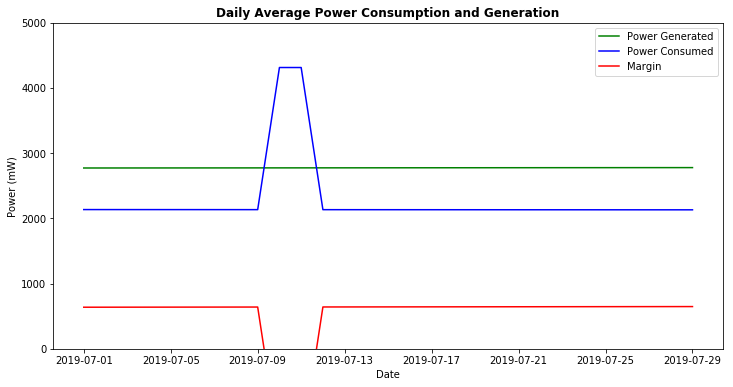

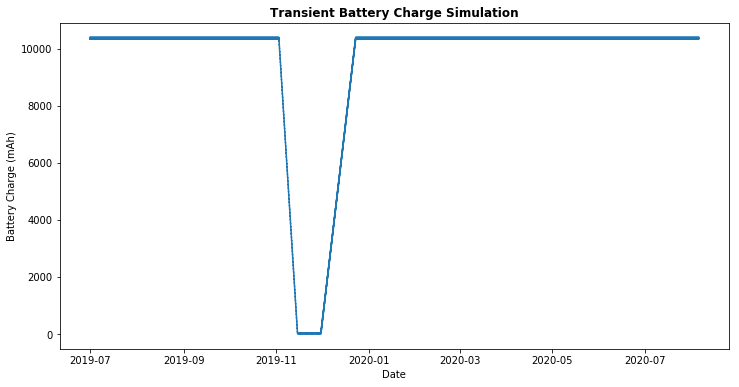

In [19]:
# 5. Create Satellite and Simulate
HeronMkII = Satellite(orb_prop, thm_prop, com_prop, gen_prop, bus, payload)
HeronMkII.simulate(conops, 30)


### 5. Mess around with parameters
You can change the inputs and see for yourself

#### Add more batteries

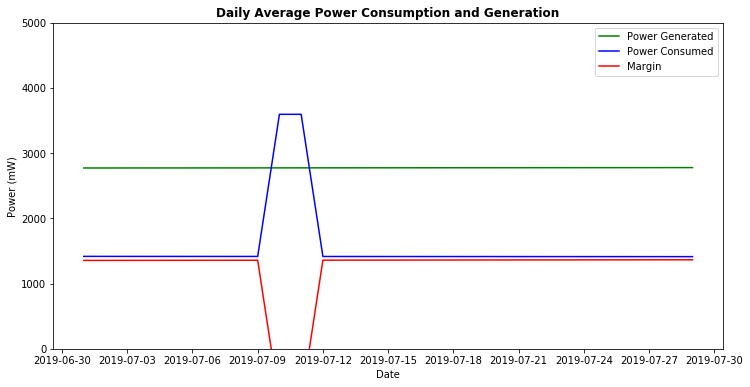

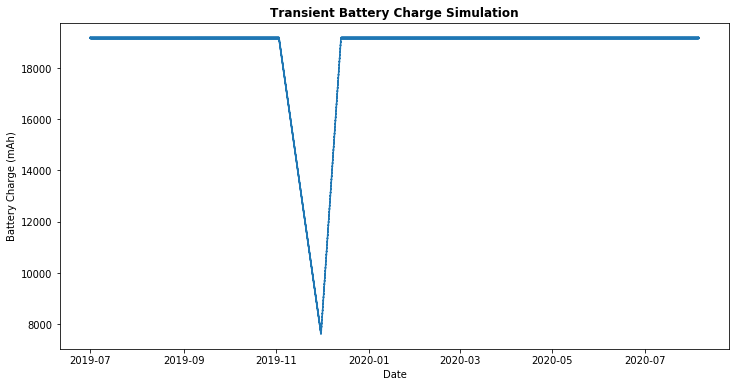

In [31]:
HeronMkII.bus.batt = Batteries(12,1600)
HeronMkII.simulate(conops, 30)

# Revert changes after simulation cause 12 batteries is ridiculous
HeronMkII.bus.batt = Batteries(4,1600)

#### Change thermal stuff

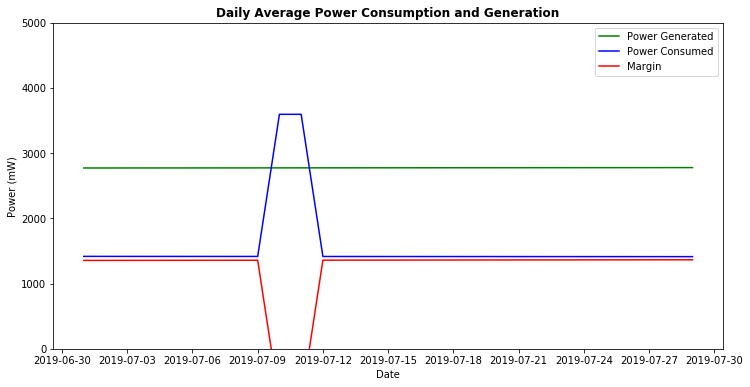

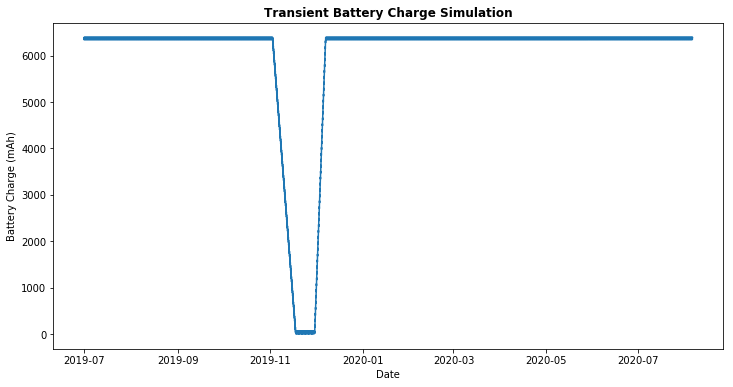

In [28]:
HeronMkII.thm_prop.a = 0.9
HeronMkII.simulate(conops,30)